In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


아래의 CLASSES의 이름은 다운 받은 폴더의 이름이 일치해야 합니다. ex) data/train

In [ ]:
# 우리가 분류할 8개의 클래스
#CLASSES = [ 'car', 'cat', 'bottle', 'bus', 'bicycle', 'bird', 'boat', 'aeroplane' ]
classes = []

학습에 필요한 상수 정의

In [ ]:
from pathlib import Path

# 학습에 필요한 상수들을 정의 합니다.
IMG_SHAPE = (224, 224, 3)
LEARNING_RATE = 2e-5
BATCH_SIZE = 16
EPOCHS = 10

# 각 이미지의 기본 주소
BASE_PATH = './drive/MyDrive/data/'
images_dir = Path(BASE_PATH).expanduser()
print(images_dir)

drive/MyDrive/data


내 드라이브 파일 마운트하고, 폴더 정보 읽어오기

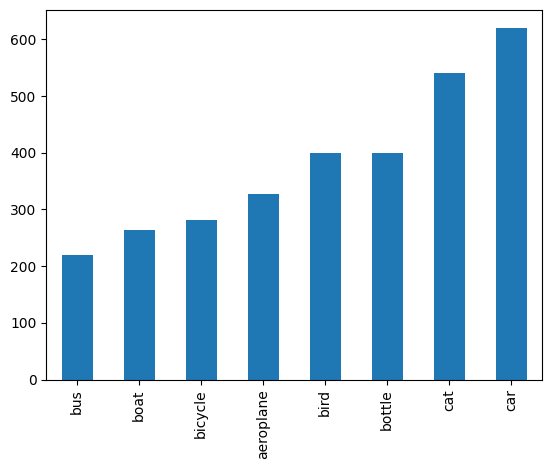

bus          219
boat         264
bicycle      281
aeroplane    328
bird         399
bottle       399
cat          540
car          621
dtype: int64


In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd

# 모델 학습에 사용할 데이터 정보를 설정합니다.
class_list = []
num_list = []

# IMAGE_BASE_PATH = './data/'
train_path = BASE_PATH + 'train/'
for folder in os.listdir(train_path):
    classes.append(folder)
    folder_size = len(os.listdir(train_path+folder))
    class_list.append(folder)
    num_list.append(folder_size)

voc_s = pd.Series(num_list,index=class_list)
voc_s.sort_values().plot(kind='bar')
plt.show()

print(voc_s.sort_values())

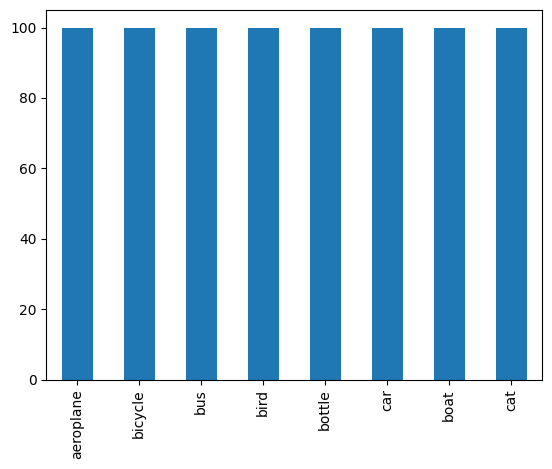

aeroplane    100
bicycle      100
bus          100
bird         100
bottle       100
car          100
boat         100
cat          100
dtype: int64


In [ ]:
# 모델 학습 검증에 사용할 데이터 내용 입니다.

class_list = []
num_list = []

#IMAGE_BASE_PATH = './data/'
valid_path = BASE_PATH + 'val/'
for folder in os.listdir(valid_path):
    folder_size = len(os.listdir(valid_path+folder))
#     print('{:<15} : {}'.format(folder,folder_size))
    class_list.append(folder)
    num_list.append(folder_size)

voc_s = pd.Series(num_list,index=class_list)
voc_s.sort_values().plot(kind='bar')
plt.show()

print(voc_s.sort_values())

**Transfer Learning 을 통해 적은 데이터를 가지고 빠르게 학습시키기**

여기서는 기존 weight(가중치) 값을 이용하여 데이터를 학습시킵니다.

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.applications import MobileNet, MobileNetV2

# base model 의 input shape, 그리고  trainable 을 false 로 합니다.

base_model = MobileNetV2(input_shape=(224,224,3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Transfer Learning 에서 정확성을 높이기 위해 마지막 3개 block 에서 모델 트레이닝합니다.

In [ ]:
from tqdm import tqdm
# tqdm: progress bar를 표시해주는 패키지

# transfer learning에서 마지막 3개 block 을 사용하여 모델을 트레이닝 합니다.
set_trainable = False
for layer in tqdm(base_model.layers):
    if layer.name in ['block_14_expand','block_15_expand', 'block_16_expand']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

100%|██████████| 154/154 [00:00<00:00, 36081.04it/s]


In [ ]:
# 레이어 구성을 살펴 봅니다.

layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]

pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,"<InputLayer name=input_layer, built=True>",input_layer,False
1,"<Conv2D name=Conv1, built=True>",Conv1,False
2,"<BatchNormalization name=bn_Conv1, built=True>",bn_Conv1,False
3,"<ReLU name=Conv1_relu, built=True>",Conv1_relu,False
4,"<DepthwiseConv2D name=expanded_conv_depthwise,...",expanded_conv_depthwise,False
...,...,...,...
149,"<Conv2D name=block_16_project, built=True>",block_16_project,True
150,"<BatchNormalization name=block_16_project_BN, ...",block_16_project_BN,True
151,"<Conv2D name=Conv_1, built=True>",Conv_1,True
152,"<BatchNormalization name=Conv_1_bn, built=True>",Conv_1_bn,True


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,947,208 (11.24 MB)

 Trainable params: 2,215,304 (8.45 MB)

 Non-trainable params: 731,904 (2.79 MB)

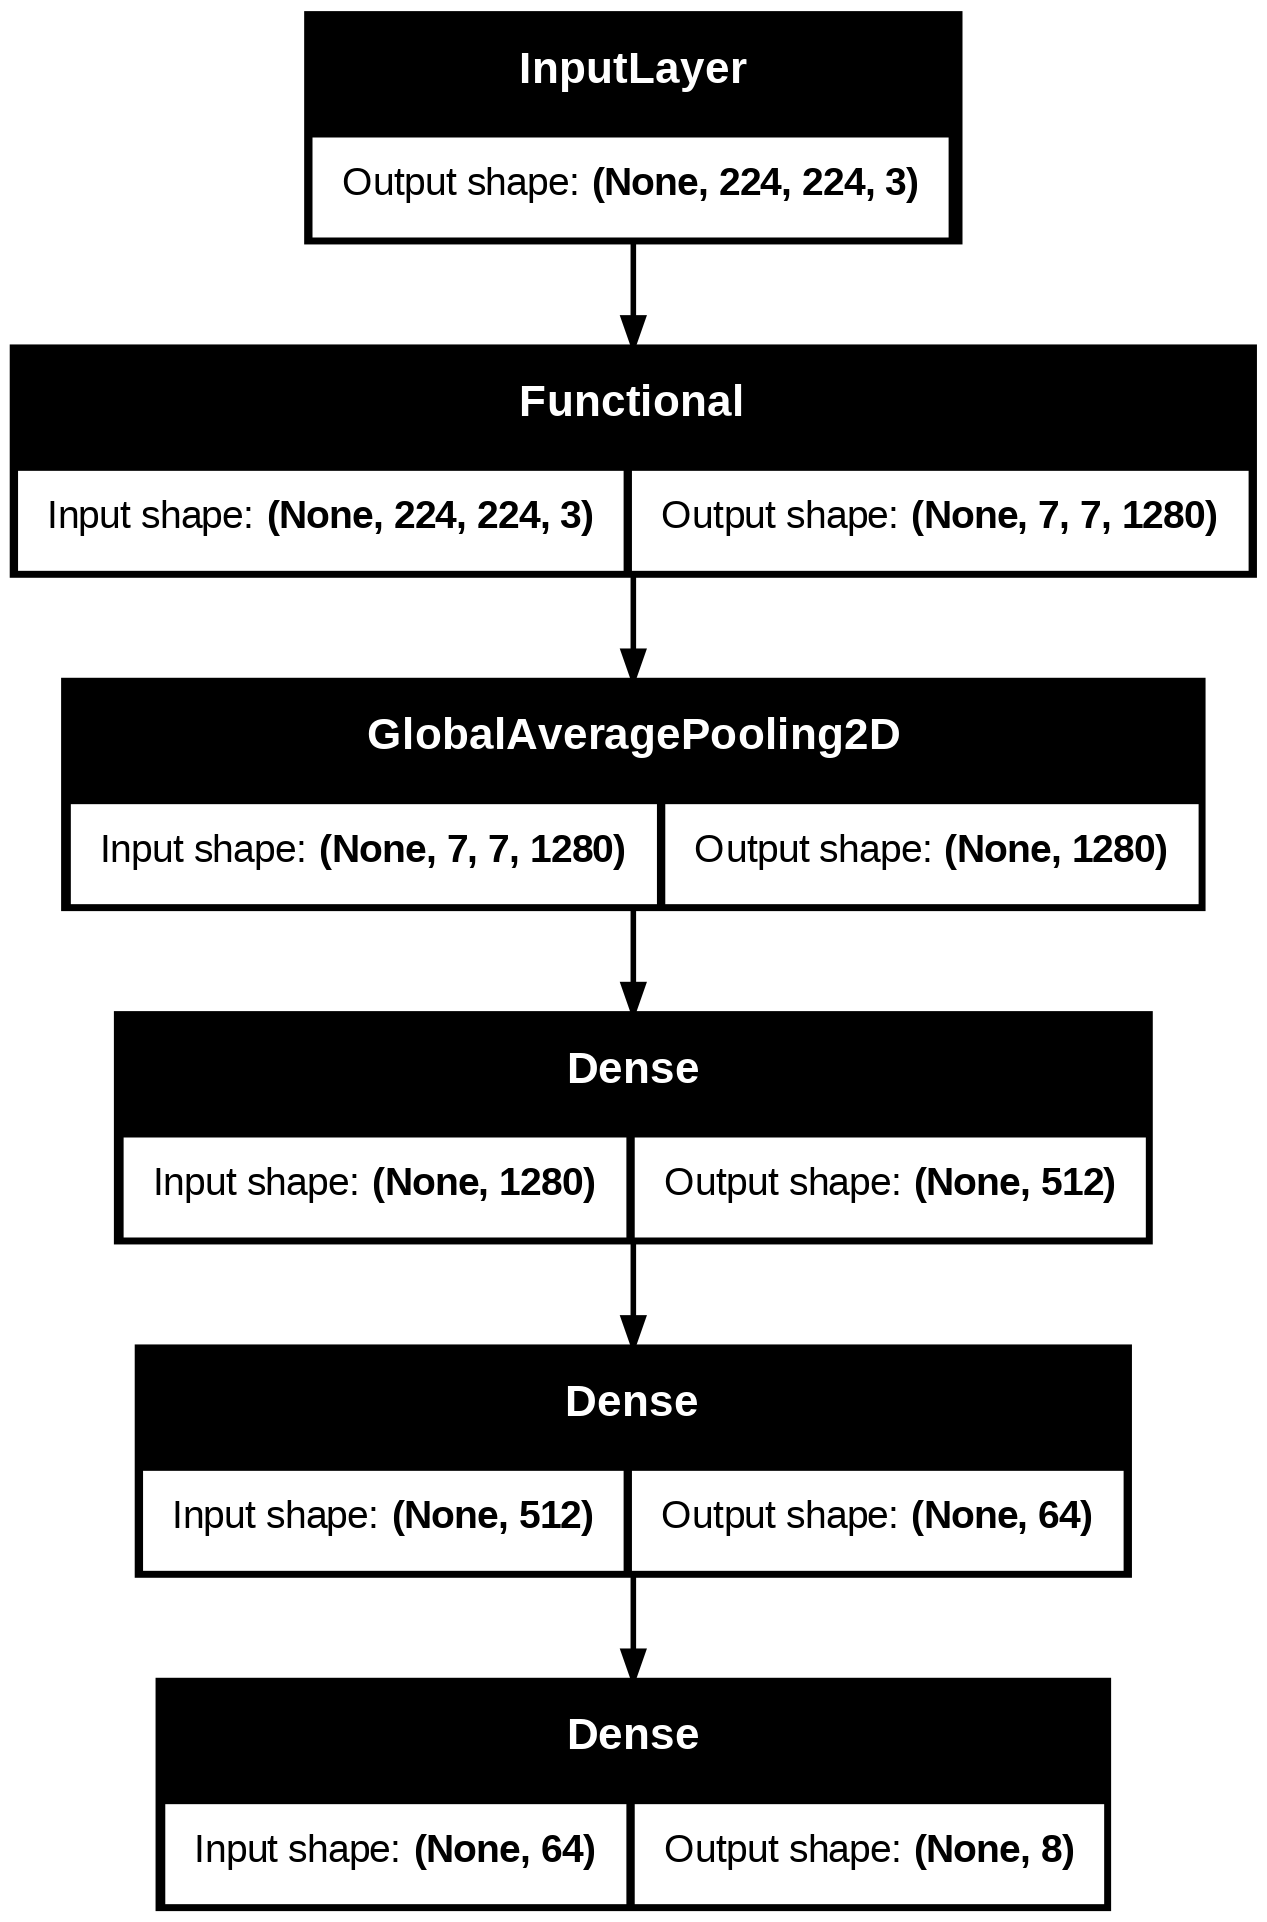

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D,GlobalAveragePooling2D, Input
from tensorflow.keras.utils import plot_model

# Define input shape explicitly
input_tensor = Input(shape=(224, 224, 3))

# Connect base_model to input tensor
x = base_model(input_tensor)

# Build the rest of the model
x = GlobalAveragePooling2D()(x)
x = Dense(512,activation='relu')(x)
x = Dense(64,activation='relu')(x)
output_tensor = Dense(len(classes), activation='softmax')(x)

# Create the model
model = Model(inputs=input_tensor, outputs=output_tensor)

model.summary()

png_file = BASE_PATH+'mobilenet_model.png'
plot_model(model,to_file=png_file,show_shapes=True)

모델 컴파일

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(learning_rate=0.0001), # transfer learning 여기서 학습률을 더 작게
              metrics=['acc'])

학습 모델 정보 설정하기

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 트레인 데이터 augmentation 의로 데이터를 증가 시킴니다.

train_datagen = ImageDataGenerator(rotation_range=30,
                                   rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest'
                                   )

train_set = train_datagen.flow_from_directory(BASE_PATH + 'train/',
                                              target_size=(224, 224),
                                              batch_size=16,
                                              shuffle=True,
                                              class_mode='categorical')

Found 3051 images belonging to 8 classes.


In [ ]:
# 학습을 완료후에 모델 성능 테스트에 사용할 데이터셋 입니다.

test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(BASE_PATH + 'val/', # Change 'val/' to 'test/' if that's where your test data is
                                            target_size=(224, 224),
                                            batch_size=16,
                                            shuffle=True, # You might want to set shuffle to False for the test set
                                            class_mode='categorical')


Found 800 images belonging to 8 classes.


In [ ]:
# 모델 트레이닝 입니다.

history = model.fit(train_set,
                    steps_per_epoch=train_set.n // train_set.batch_size,
                    epochs=20)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


190/190 ━━━━━━━━━━━━━━━━━━━━ 715s 4s/step - acc: 0.5545 - loss: 1.2710
Epoch 2/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 316us/step - acc: 0.6250 - loss: 0.9172
Epoch 3/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


190/190 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - acc: 0.7815 - loss: 0.6271
Epoch 4/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 97us/step - acc: 0.8750 - loss: 0.3232   
Epoch 5/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - acc: 0.7779 - loss: 0.6135
Epoch 6/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 137us/step - acc: 0.9375 - loss: 0.2676
Epoch 7/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - acc: 0.8223 - loss: 0.5210
Epoch 8/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 84us/step - acc: 0.7500 - loss: 0.7245   
Epoch 9/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - acc: 0.8256 - loss: 0.4712
Epoch 10/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 83us/step - acc: 0.7500 - loss: 0.5668   
Epoch 11/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - acc: 0.8471 - loss: 0.4249
Epoch 12/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 108us/step - acc: 0.9375 - loss: 0.4748  
Epoch 13/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - acc: 0.8571 - loss: 0.3948
Epoch 14/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 83us/step - acc: 0.8125 - loss: 0.6357   
Epoch 

학습된 모델을 저장

In [ ]:
model.save(BASE_PATH+'bin/mobilenetv2_class8.h5')

cvt_model = tf.keras.models.load_model(BASE_PATH+'bin/mobilenetv2_class8.h5')
tf.saved_model.save(cvt_model, BASE_PATH+'bin/mobilenetv2_class')

test_set.class_indices.items()

In [ ]:
import pickle

# key 와 value 값을 바꾸어 줍니다.
class8 = dict()
for key,value in test_set.class_indices.items():
    class8[value] = key

with open(BASE_PATH+'bin/class8.pickle', 'wb') as f:
    pickle.dump(class8, f)

In [ ]:
class8

{0: 'aeroplane',
 1: 'bicycle',
 2: 'bird',
 3: 'boat',
 4: 'bottle',
 5: 'bus',
 6: 'car',
 7: 'cat'}

모델 평가하기

In [ ]:
# 트레인 데이터와 테스트 데이터 셋으로 loss 와 accuracy 측정합니다.
train_res = model.evaluate(train_set)
print('Train Loss : {}'.format(train_res[0]))
print('Train Accuracy : {}'.format(train_res[1]))

test_res = model.evaluate(test_set)
print('Test Loss : {}'.format(test_res[0]))
print('Test Accuracy : {}'.format(test_res[1]))

191/191 ━━━━━━━━━━━━━━━━━━━━ 177s 911ms/step - acc: 0.8857 - loss: 0.2834
Train Loss : 0.25777536630630493
Train Accuracy : 0.8954440951347351


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 188s 4s/step - acc: 0.7839 - loss: 0.8674
Test Loss : 0.806876003742218
Test Accuracy : 0.7774999737739563


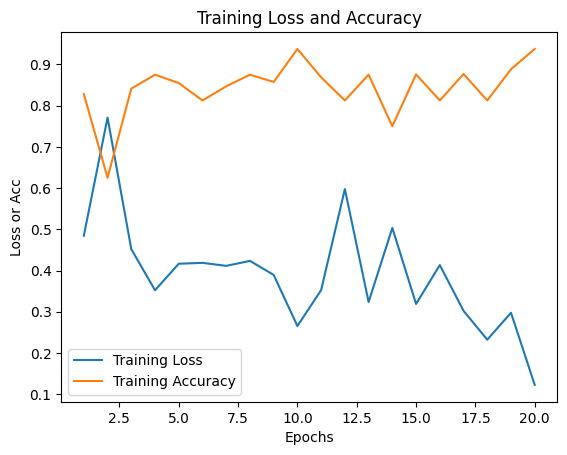

In [ ]:
# loss 측정값의 시각화 입니다.

loss = history.history['loss']
acc = history.history['acc']
epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,label='Training Loss')
plt.plot(epochs,acc,label='Training Accuracy')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss or Acc')
plt.legend()

plt.show()

모델 테스트해보기

In [ ]:
import cv2
from tensorflow.keras.models import load_model
import numpy as np

# 추론하기 위한 작업입니다. 모델 설정, 입력 데이터 전처리.
def predict_test_img(path):
    img = cv2.imread(path)

    model = load_model(BASE_PATH+'bin/mobilenetv2_class8.h5')

    print('Original Shape : ',img.shape)

    img = cv2.resize(img, (224,224), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    print('Resized Shape : ',img.shape)
    plt.imshow(img)
    plt.show()
    class8 = []

    predicted_result = model.predict(np.expand_dims(img,axis=0))
    ans = np.round(predicted_result).astype(int)
    with open(BASE_PATH+'bin/class8.pickle','rb') as f:
        class8 = pickle.load(f)
    res = -1
    for x in range(8):
      if ans[0][x] == 1: res = x
    print('Predict : {}'.format(class8[res]))

    pd.DataFrame(predicted_result,columns=class8.values()).iloc[0].plot(kind='bar')
    plt.show()

Original Shape :  (375, 500, 3)
Resized Shape :  (224, 224, 3)


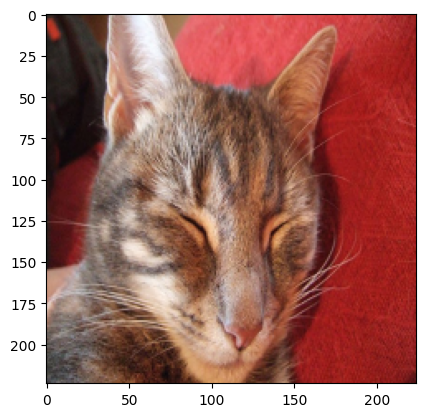

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predict : cat


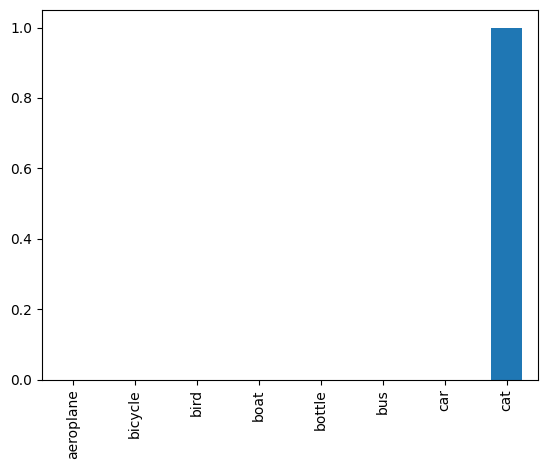

In [ ]:
# 기존에 사용되지 않았던 임의 데이터를 추론 하기
predict_test_img(BASE_PATH+'val/cat/2008_000056.jpg')